## Data mining with Apache Spark


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

StatementMeta(NEWPOOL, 1, 2, Finished, Available)

In [57]:
import numpy as np

StatementMeta(NEWPOOL, 1, 58, Finished, Available)

In [2]:
from azureml.opendatasets import NycTlcYellow #Get sample dataset
from datetime import datetime
from dateutil import parser

# Get a sample set of data
end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
df = nyc_tlc.to_spark_dataframe()

StatementMeta(NEWPOOL, 1, 3, Finished, Available)

In [3]:
# Filter the dataset 
from pyspark.sql.functions import *

filtered_df = df.select('vendorID', 'passengerCount', 'tripDistance','paymentType', 'fareAmount', 'tipAmount'\
                                , date_format('tpepPickupDateTime', 'hh').alias('hour_of_day')\
                                , dayofweek('tpepPickupDateTime').alias('day_of_week')\
                                , dayofmonth(col('tpepPickupDateTime')).alias('day_of_month'))\
                            .filter((df.passengerCount > 0)\
                                & (df.tipAmount >= 0)\
                                & (df.fareAmount >= 1) & (df.fareAmount <= 250)\
                                & (df.tripDistance > 0) & (df.tripDistance <= 200))

filtered_df.createOrReplaceTempView("taxi_dataset") # Create temporal data to use with SQL or other languages

StatementMeta(NEWPOOL, 1, 4, Finished, Available)

### Analyze with SQL

In [4]:
%%sql
-- Analyze some info inside the temp table
SELECT 
    day_of_month
    , MIN(tipAmount) AS minTipAmount
    , MAX(tipAmount) AS maxTipAmount
    , AVG(tipAmount) AS avgTipAmount
    , AVG(fareAmount) as fareAmount
FROM taxi_dataset 
GROUP BY day_of_month
ORDER BY day_of_month ASC

StatementMeta(NEWPOOL, 1, 5, Finished, Available)

<Spark SQL result set with 31 rows and 5 fields>

### With Matplotlib

In [5]:
# To make development easier, faster and less expensive down sample for now
sampled_taxi_df = filtered_df.sample(True, 0.001, seed=1234)

# The charting package needs a Pandas dataframe or numpy array do the conversion
sampled_taxi_pd_df = sampled_taxi_df.toPandas()

StatementMeta(NEWPOOL, 1, 6, Finished, Available)

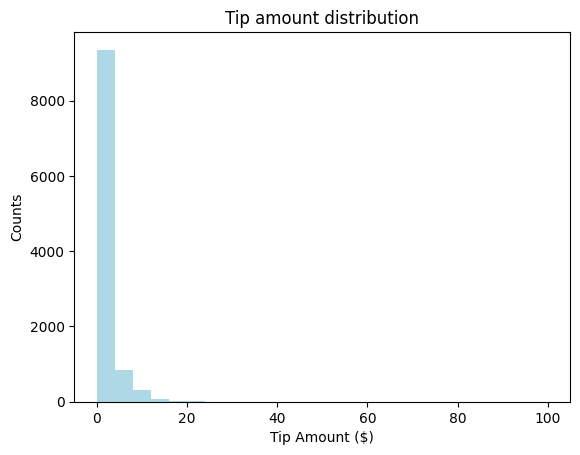

In [6]:
# Look at tips by count histogram using Matplotlib

ax1 = sampled_taxi_pd_df['tipAmount'].plot(kind='hist', bins=25, facecolor='lightblue')
ax1.set_title('Tip amount distribution')
ax1.set_xlabel('Tip Amount ($)')
ax1.set_ylabel('Counts')
plt.suptitle('')
plt.show()

StatementMeta(NEWPOOL, 1, 7, Finished, Available)

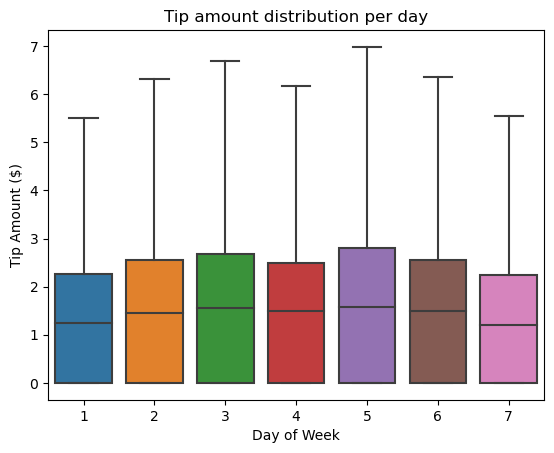

In [6]:
# View the distribution of tips by day of week using Seaborn
ax = sns.boxplot(x="day_of_week", y="tipAmount",data=sampled_taxi_pd_df, showfliers = False)
ax.set_title('Tip amount distribution per day')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Tip Amount ($)')
plt.show()

StatementMeta(NEWPOOL, 1, 8, Finished, Available)

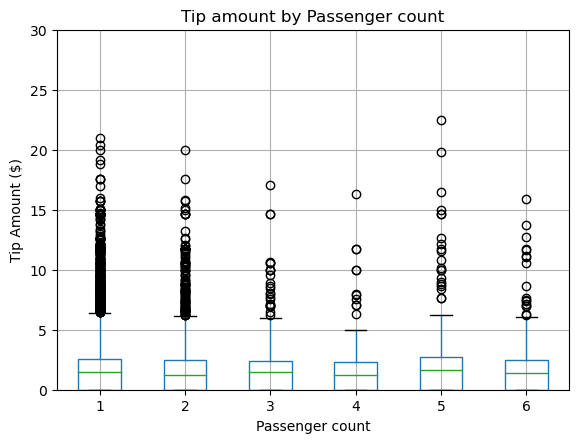

In [7]:
# How many passengers tipped by various amounts 
ax2 = sampled_taxi_pd_df.boxplot(column=['tipAmount'], by=['passengerCount'])
ax2.set_title('Tip amount by Passenger count')
ax2.set_xlabel('Passenger count')
ax2.set_ylabel('Tip Amount ($)')
ax2.set_ylim(0,30)
plt.suptitle('')
plt.show()

StatementMeta(NEWPOOL, 1, 9, Finished, Available)

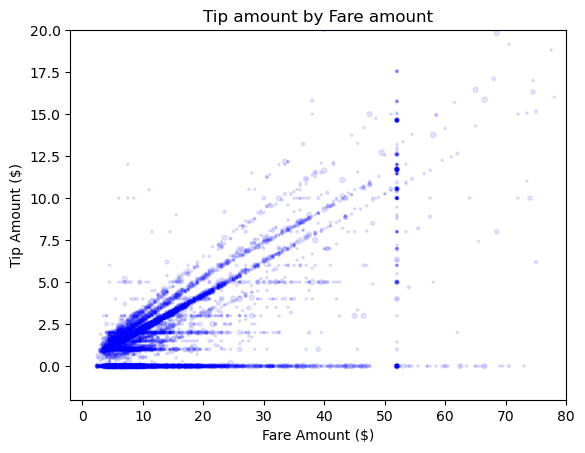

In [8]:
# Look at the relationship between fare and tip amounts

ax = sampled_taxi_pd_df.plot(kind='scatter', x= 'fareAmount', y = 'tipAmount', c='blue', alpha = 0.10, s=2.5*(sampled_taxi_pd_df['passengerCount']))
ax.set_title('Tip amount by Fare amount')
ax.set_xlabel('Fare Amount ($)')
ax.set_ylabel('Tip Amount ($)')
plt.axis([-2, 80, -2, 20])
plt.suptitle('')
plt.show()

# Other tasks


#### Show the data inside the dataframe


In [9]:
print(df)

StatementMeta(NEWPOOL, 1, 10, Finished, Available)

DataFrame[vendorID: string, tpepPickupDateTime: timestamp, tpepDropoffDateTime: timestamp, passengerCount: int, tripDistance: double, puLocationId: string, doLocationId: string, startLon: double, startLat: double, endLon: double, endLat: double, rateCodeId: int, storeAndFwdFlag: string, paymentType: string, fareAmount: double, extra: double, mtaTax: double, improvementSurcharge: string, tipAmount: double, tollsAmount: double, totalAmount: double, puYear: int, puMonth: int]


#### Generate a dataframe called 'filtered_df2' with variables 'vendorID', 'passengerCount', 'tripDistance','fareAmount', 'tipAmount', 'tipped' where tipAmount and tripDistance are greater than or equal to 0 and fareAmount greater than or equal to 1. Moreover, tipped is an extra column that has a value of 1 when tipAmount is greater than 0 and a value of 0 when it is not.

In [21]:
filtered_df2 = df.select('vendorID', 'passengerCount', 'tripDistance','fareAmount', 'tipAmount', when(col('tipAmount') > 0, 1).otherwise(0).alias('tipped'))\
.filter((df.fareAmount >= 1)\
                                & (df.tipAmount >= 0)\
                                & (df.tripDistance > 0))
                    


StatementMeta(NEWPOOL, 1, 22, Finished, Available)

In [23]:
display(filtered_df2)
filtered_df2.createOrReplaceTempView("taxes_dataset2") # Create temporal data to use with SQL or other languages

StatementMeta(NEWPOOL, 1, 24, Finished, Available)

SynapseWidget(Synapse.DataFrame, 1163296f-6937-4505-a493-5c08011887b6)

#### Calculate and generate an avg. fareAmount vs vendorID plot.

In [26]:
%%sql

SELECT 
    vendorID
    , AVG(fareAmount) as fareAmount
FROM taxes_dataset2 
GROUP BY vendorID
ORDER BY vendorID

StatementMeta(NEWPOOL, 1, 27, Finished, Available)

<Spark SQL result set with 3 rows and 2 fields>

#### Generate a boxplot graph of passengerCount vs fareAmount


StatementMeta(NEWPOOL, 1, 29, Finished, Available)

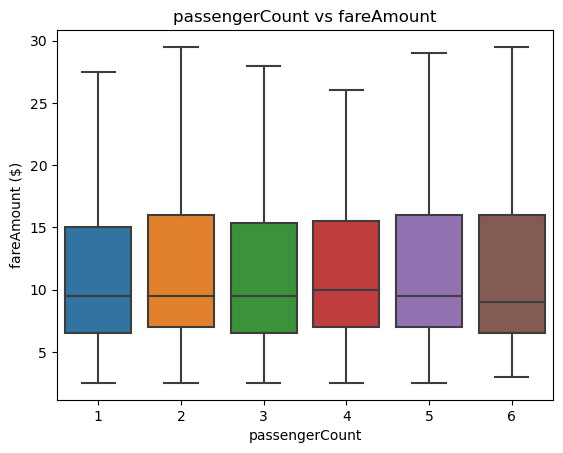

In [28]:
ax = sns.boxplot(x="passengerCount", y="fareAmount",data=sampled_taxi_pd_df, showfliers = False)
ax.set_title('passengerCount vs fareAmount')
ax.set_xlabel('passengerCount')
ax.set_ylabel('fareAmount ($)')
plt.show()

#### Generate a seaborn heatmap graph with the sampled_taxi_pd_df dataframe. You can find more information at https://seaborn.pydata.org/generated/seaborn.heatmap.html.

In [89]:
print(sampled_taxi_pd_df)

StatementMeta(NEWPOOL, 1, 90, Finished, Available)

      vendorID  passengerCount  tripDistance paymentType  fareAmount  \
0            2               1          1.15           1         7.5   
1            2               1          2.51           1        14.5   
2            2               1         20.26           1        52.0   
3            1               1          2.60           1        12.0   
4            2               5         12.48           1        40.0   
...        ...             ...           ...         ...         ...   
10535        2               1          0.62           2         4.5   
10536        2               5          0.90           2         7.5   
10537        2               2          0.53           1         5.0   
10538        1               1          7.10           1        26.0   
10539        2               1          1.30           2         9.5   

       tipAmount hour_of_day  day_of_week  day_of_month  
0           1.00          02            1             6  
1           2.00   

StatementMeta(NEWPOOL, 1, 93, Finished, Available)

       vendorID  passengerCount  tripDistance  paymentType  fareAmount  \
0             2               1          1.15            1         7.5   
1             2               1          2.51            1        14.5   
2             2               1         20.26            1        52.0   
3             1               1          2.60            1        12.0   
4             2               5         12.48            1        40.0   
...         ...             ...           ...          ...         ...   
10535         2               1          0.62            2         4.5   
10536         2               5          0.90            2         7.5   
10537         2               2          0.53            1         5.0   
10538         1               1          7.10            1        26.0   
10539         2               1          1.30            2         9.5   

       tipAmount  hour_of_day  day_of_week  day_of_month  
0           1.00            2            1          

<AxesSubplot: >

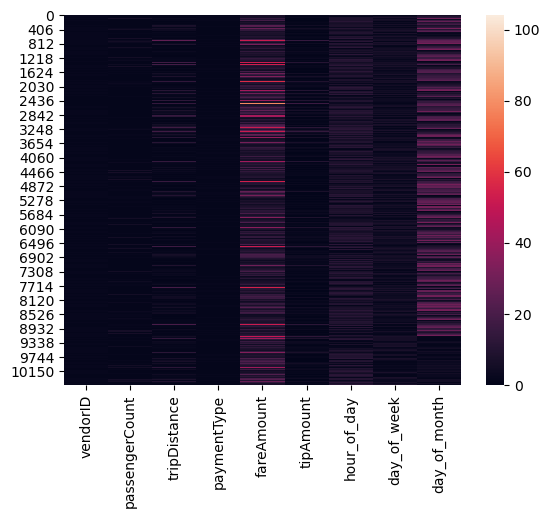

In [92]:
array2d = sampled_taxi_pd_df.apply(pd.to_numeric)
print(array2d)
sns.heatmap(array2d, fmt="d")

#### Generate a seaborn pairplot graph with the filtered_df2 dataframe comparing the 'tipped' column. You can find more information at https://seaborn.pydata.org/generated/seaborn.pairplot.html.

In [94]:
sns.pairplot(filtered_df2.toPandas(), hue="tipped")

StatementMeta(NEWPOOL, 1, 95, Finished, Available)

/home/trusted-service-user/cluster-env/env/lib/python3.10/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
